Original notebook from Medium article, paths need to be fixed

In [0]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools as it



from sklearn.cluster import KMeans

sns.set_context('talk')

# originally from https://github.com/woodnathan/MarioKart8-Stats, added DLC and fixed a few typos
bodies = pd.read_csv('../data/bodies.csv')
chars = pd.read_csv('../data/characters.csv')
gliders = pd.read_csv('../data/gliders.csv')
tires = pd.read_csv('../data/tires.csv')

# use only stock (non-DLC) characters / karts / tires
chars = chars.loc[chars['DLC']==0]
bodies = bodies.loc[bodies['DLC']==0]
tires = tires.loc[tires['DLC']==0]
gliders = gliders.loc[gliders['DLC']==0]

stat_cols = bodies.columns[2:-1]
main_cols = ['Weight','Speed','Acceleration','Handling','Traction']

# lots of characters/karts/tires are exactly the same. here we just want one from each stat type
chars_unique = (chars
                .drop_duplicates(subset=stat_cols)
                .set_index('Character')[stat_cols])
bodies_unique = (bodies
                 .drop_duplicates(subset=stat_cols)
                 .set_index('Body')[stat_cols])
tires_unique = (tires
                .drop_duplicates(subset=stat_cols)
                .set_index('Tire')[stat_cols])

n_uniq_chars = len(chars_unique)
n_uniq_bodies = len(bodies_unique)
n_uniq_tires = len(tires_unique)

# add a column indicating which category each character/kart/tire is in
chars['char_class'] = KMeans(n_uniq_chars, random_state=0).fit_predict(chars[stat_cols])
bodies['body_class'] = KMeans(n_uniq_bodies).fit_predict(bodies[stat_cols])
tires['tire_class'] = KMeans(n_uniq_tires).fit_predict(tires[stat_cols])

# change the character class labels so that they correspond to weight order
# without DLC
char_class_dict = dict(zip([3, 0, 5, 4, 2, 6, 1], [0, 1, 2, 3, 4, 5, 6]))
# with DLC
# char_class_dict = dict(zip([0, 3, 2, 7, 8, 4, 1, 6, 5], [0, 1, 2, 3, 4, 5, 6, 7, 8]))
chars['char_class'] = chars['char_class'].apply(lambda c: char_class_dict[c])

# only two types of gliders, one of which is pretty clearly just better
glider_best = gliders.loc[gliders['Glider']=='Flower']
                          
                          

def check(char_name, body_type, tire_type):
    # find the stats for each element of the configuration
    character = chars.loc[chars['Character']==char_name]
    kart = bodies.loc[bodies['Body']==body_type]
    wheels = tires.loc[tires['Tire']==tire_type]

    # the total stats for the configuration are just the sum of the components
    stats = pd.concat([character[stat_cols], kart[stat_cols], wheels[stat_cols], glider_best[stat_cols]]).sum()
    
    # index the row by the configuration (character, kart, tire)
    index = pd.MultiIndex.from_tuples([(char_name, body_type, tire_type)], names=['Character', 'Body', 'Tire'])
    
    df = pd.DataFrame(stats).transpose()
    df.index = index
    return df

# generate list of tuples for every possible configuration
config_all = it.product(chars_unique.index, bodies_unique.index, tires_unique.index)

# generate a dataframe with stats for each unique configuration
config_base = pd.DataFrame()
for (c,b,t) in config_all:
    this_config = check(c,b,t)
    config_base = config_base.append(this_config)



In [0]:
# returns True if the row is at the pareto frontier for variables xlabel and ylabel
def is_pareto_front(row, xlabel, ylabel):
    
    x = row[xlabel]
    y = row[ylabel]
    
    # look for points with the same y value but larger x value
    is_max_x = config_base.loc[config_base[ylabel]==y].max()[xlabel] <= x
    # look for points with the same x value but larger y value
    is_max_y = config_base.loc[config_base[xlabel]==x].max()[ylabel] <= y
    # look for points that are larger in both x and y
    is_double = len(config_base.loc[(config_base[xlabel]>x) & (config_base[ylabel]>y)])==0
    
    return is_max_x and is_max_y and is_double

# array of True/False indicating whether the corresponding row is on the pareto frontier
is_accel_pareto = config_base.apply(lambda row: is_pareto_front(row, 'Speed', 'Acceleration'), axis=1)
is_hand_pareto = config_base.apply(lambda row: is_pareto_front(row, 'Speed', 'Handling'), axis=1)

is_pareto=is_accel_pareto & is_hand_pareto
# just the configurations that are on the pareto frontier
config_pareto = config_base.ix[is_pareto]

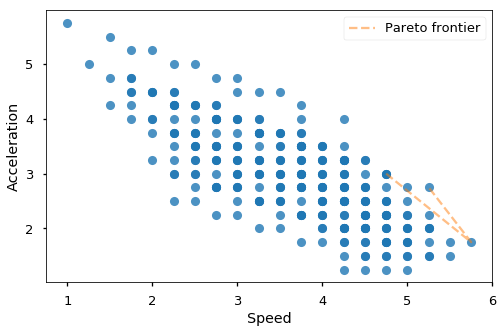

In [0]:
# plot all the configurations
fig, ax = plt.subplots(1,1, figsize=(8,5))
sns.regplot(x='Speed', y='Acceleration', data=config_base, fit_reg=False, ax=ax)
            
# plot the pareto frontier
plt.plot(config_pareto['Speed'], config_pareto['Acceleration'], '--', label='Pareto frontier', alpha=0.5)

plt.xlim([0.75,6]);
plt.legend(loc='best');

In [0]:
config_pareto

Speed  Speed (Water)  Speed (Air)  \
Character   Body          Tire                                       
Donkey Kong Sports Bike   Slick   4.75           3.75          4.5   
Wario       Gold Standard Slick   5.75           4.50          5.5   
            Sports Bike   Slick   5.25           4.25          5.0   

                                 Speed (Anti-Gravity)  Acceleration  Weight  \
Character   Body          Tire                                                
Donkey Kong Sports Bike   Slick                  4.75          3.00     4.0   
Wario       Gold Standard Slick                  5.25          1.75     5.0   
            Sports Bike   Slick                  5.25          2.75     4.5   

                                 Handling  Handling (Water)  Handling (Air)  \
Character   Body          Tire                                                
Donkey Kong Sports Bike   Slick      3.50              3.50            3.50   
Wario       Gold Standard Slick      2.25              2.25            2.25   
            Sports Bike   Slick      3.00              3.00            3.00   

                                 Handling (Anti-Gravity)  Traction  Mini Turbo  
Character   Body          Tire                                                  
Donkey Kong Sports Bike   Slick                     3.50      1.25        3.00  
Wario       Gold Standard Slick                     2.25      1.25        1.75  
            Sports Bike   Slick                     3.00      1.00        2.75